<a href="https://colab.research.google.com/github/GusdPaula/postgraduation_fiap/blob/main/fase_5/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os

# Para NLP
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para deep learning e validação do modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/5b00193e34c5955ba16b315efe415119fdce3bce/Aula%204%20-%20Redes%20Neurais%20Recorrentes/bbc-text.csv", sep=',')

In [ ]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.shape

(2225, 2)

In [ ]:
df.isnull().sum()

,0
category,0
text,0


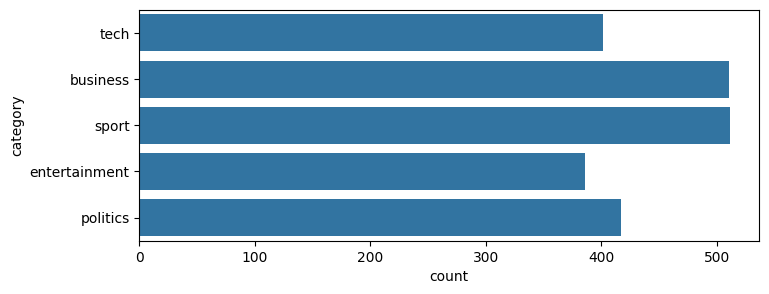

In [ ]:
plt.figure(figsize=(8, 3))
sns.countplot(df['category'])
plt.show()

In [ ]:
from string import whitespace
def limpeza_texto(text):
  # regex para limpar o texto

  whitespace = re.compile(r'\s+')
  user = re.compile(r'(?i)@[a-z0-9_]+')
  text = whitespace.sub(' ', text)
  text = user.sub('', text)
  text = re.sub("\d+", "", text)
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
  text = text.lower()

  text = [word for word in text.split() if word not in list(STOPWORDS)]

  sentence = []

  for word in text:
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))


  return ' '.join(sentence)

In [ ]:

print("Texto antes da limpeza:\n",df['text'][0])
print("---"*100)
print("Texto depois da limpeza:\n",limpeza_texto(df['text'][0]))

Texto antes da limpeza:
 tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are als

In [ ]:
df['text'] = df['text'].apply(limpeza_texto)

In [ ]:
samples = list(df['text'][:5].values)

token_index = {}

for sample in samples:
  for word in sample.split():
    if word not in token_index:
      token_index[word] = len(token_index) + 1

max_length = 15

results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

In [ ]:
results.shape

(5, 15, 680)

In [ ]:
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)
    results[i, j, index] = 1

In [ ]:
results.shape

(5, 15, 680)

In [ ]:
token_index

{'tv': 1,
 'future': 2,
 'hand': 3,
 'viewers': 4,
 'home': 5,
 'theatre': 6,
 'systems': 7,
 'plasma': 8,
 'highdefinition': 9,
 'tvs': 10,
 'digital': 11,
 'video': 12,
 'recorders': 13,
 'move': 14,
 'live': 15,
 'room': 16,
 'way': 17,
 'people': 18,
 'watch': 19,
 'will': 20,
 'radically': 21,
 'different': 22,
 'five': 23,
 'years': 24,
 'time': 25,
 'accord': 26,
 'expert': 27,
 'panel': 28,
 'gather': 29,
 'annual': 30,
 'consumer': 31,
 'electronics': 32,
 'show': 33,
 'las': 34,
 'vegas': 35,
 'discuss': 36,
 'new': 37,
 'technologies': 38,
 'impact': 39,
 'one': 40,
 'favourite': 41,
 'pastimes': 42,
 'us': 43,
 'lead': 44,
 'trend': 45,
 'program': 46,
 'content': 47,
 'deliver': 48,
 'via': 49,
 'network': 50,
 'cable': 51,
 'satellite': 52,
 'telecoms': 53,
 'company': 54,
 'broadband': 55,
 'service': 56,
 'providers': 57,
 'front': 58,
 'portable': 59,
 'devices': 60,
 'talkedabout': 61,
 'ces': 62,
 'personal': 63,
 'dvr': 64,
 'pvr': 65,
 'settop': 66,
 'box': 67,
 's

In [ ]:
X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

print(X.shape)
print(y.shape)

(2225,)
(2225,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
train_padseq = pad_sequences(train_seq, maxlen=200)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=100)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=200)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22639 unique tokens.


In [ ]:
max_words = 1500
total_words = len(word_index)
maxlen = 200

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [ ]:
total_words

22639

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen)) # camada de embeddings, utilizando o total de palavras do corpus, com 70 neuronios de dimensão e entrada do tamanho da rede é de maxlen (200)
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True))) # cada unidade de tempo da RNN tem acesso a informações de contexto tanto passadas quanto futuras
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True))) # return_sequences=True indica que essa camada retorna sequências em vez de um único vetor
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='min')

In [ ]:
checkpointer = ModelCheckpoint(filepath='bestvalue.keras', monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
callback_list = [checkpointer, earlystopping]

In [ ]:
history = model.fit(train_padseq, y_train, batch_size=120, epochs=15, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 797ms/step - accuracy: 0.2275 - loss: 1.7821 - val_accuracy: 0.2444 - val_loss: 1.6483
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 696ms/step - accuracy: 0.2304 - loss: 1.7389 - val_accuracy: 0.2079 - val_loss: 1.6835
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 605ms/step - accuracy: 0.2041 - loss: 1.7362 - val_accuracy: 0.2303 - val_loss: 1.6545
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 691ms/step - accuracy: 0.1984 - loss: 1.7651 - val_accuracy: 0.2612 - val_loss: 1.6332
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 718ms/step - accuracy: 0.2078 - loss: 1.7092 - val_accuracy: 0.2528 - val_loss: 1.6269
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 737ms/step - accuracy: 0.2274 - loss: 1.6777 - val_accuracy: 0.2247 - val_loss: 1.6315
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 574ms/step - accuracy: 0.2327 - loss: 1.6638 - val_accuracy: 0.2135 - val_loss: 1.6062
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step - accuracy: 0.2331 - loss: 1.6292 - val_accurac

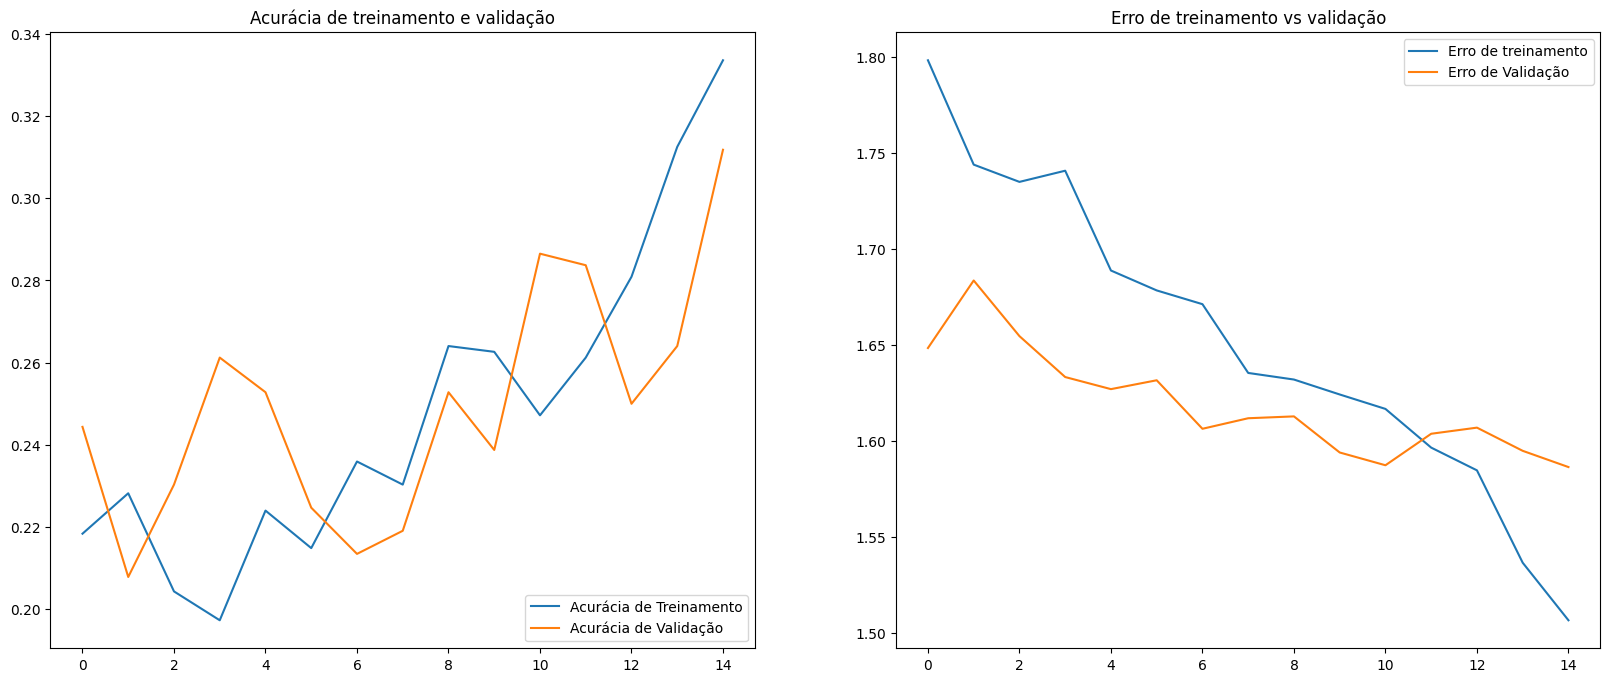

In [ ]:
# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True))) # acrescentando camada LSTM
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True))) # acrescentando camada LSTM
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20)) # o GRU é projetado para superar o problema do desaparecimento de gradientes nas RNNs tradicionais e é especialmente eficaz em lidar com sequências de dados temporais.
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer='adam', # Adam, que é um algoritmo de otimização amplamente utilizado para ajustar os pesos da rede neural durante o treinamento.
            loss='categorical_crossentropy', # função de perda a ser minimizada durante o treinamento
            metrics=['accuracy'] # métrica de avaliação para monitorar durante o treinamento
            )
# Configurando early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Monitora a métrica de precisão durante o treinamento
                                             patience=3, # número de épocas que o treinamento pode continuar sem melhorar a métrica monitorada antes de parar
                                              verbose=1, # mostra mensagens de progresso durante o treinamento
                                              mode='min' # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"
                                             )
# salva o modelo com os melhores valores encontrados durante o treinamento
checkpointer = ModelCheckpoint(filepath='bestvalue.keras',monitor='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# treinando o modelo
history = model2.fit(train_padseq, y_train,
                   batch_size=120,
                    epochs=15,
                    validation_split=0.2
                   )

# validando o modelo
test_loss, test_acc = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.1865 - loss: 1.6704 - val_accuracy: 0.2725 - val_loss: 1.5889
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2261 - loss: 1.6467 - val_accuracy: 0.2416 - val_loss: 1.6000
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2097 - loss: 1.6417 - val_accuracy: 0.2219 - val_loss: 1.6026
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.2132 - loss: 1.6356 - val_accuracy: 0.2163 - val_loss: 1.6095
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2413 - loss: 1.6234 - val_accuracy: 0.2191 - val_loss: 1.6047
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.2022 - loss: 1.6354 - val_accuracy: 0.2191 - val_loss: 1.6077
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2418 - loss: 1.6186 - val_accuracy: 0.2191 - val_loss: 1.6034
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.2558 - loss: 1.6068 - val_accuracy: 0.3680 - val_loss:

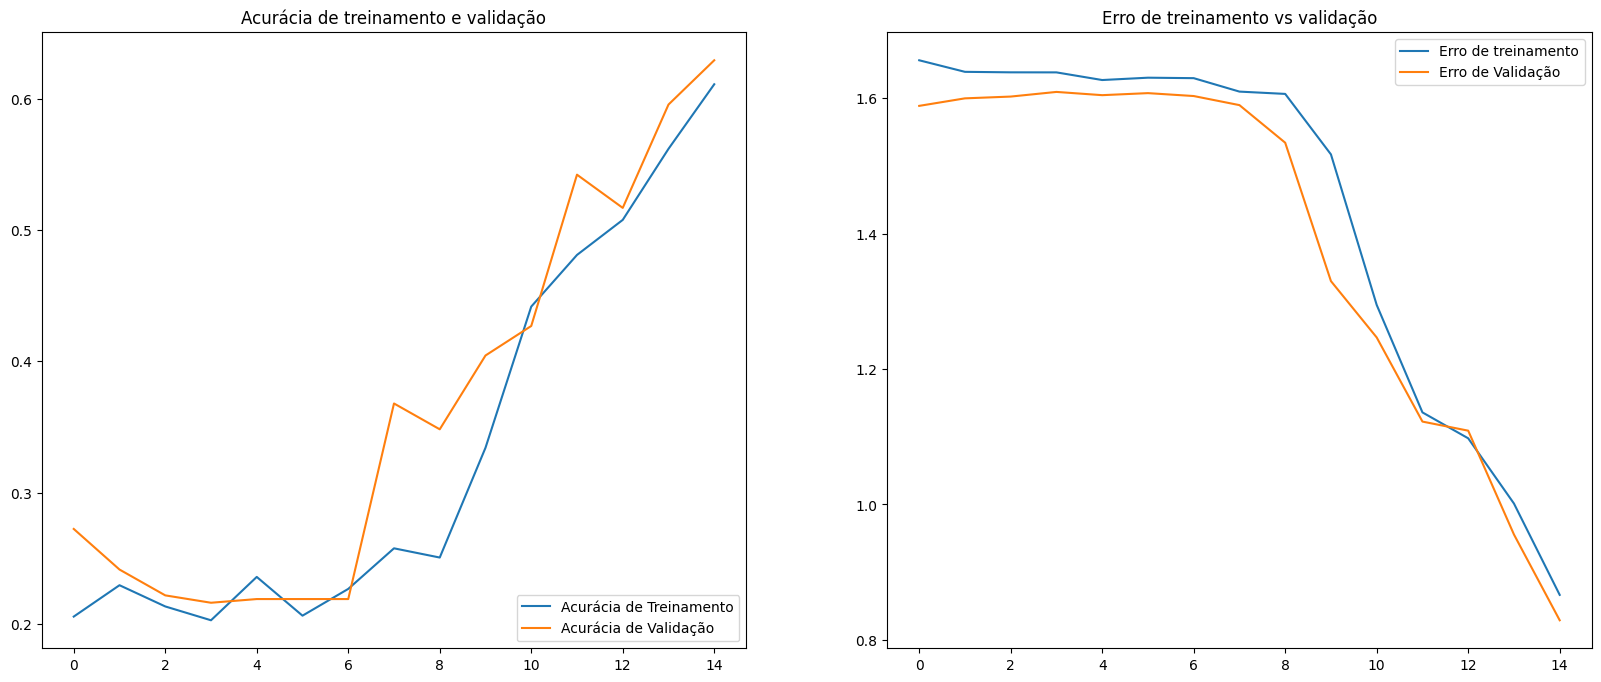

In [ ]:
# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()